In [1]:
# RQ1.2: Model Provenance Tracking in Jupyter Notebook using MLflow
# Updated with automatic logging of environment, Git, model config, and FAIR-aligned metadata

# ============================
# ⚙️ Install Dependencies (if needed in Colab)
# ============================
!pip install mlflow scikit-learn pandas numpy matplotlib seaborn shap

# ============================
# 📦 Imports
# ============================

In [16]:
import os
import time
import json
import psutil
import platform
import git
import mlflow
import shap
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve
)
from mlflow import MlflowClient

In [3]:
# ============================
# 📂 Setup MLflow
# ============================
project_dir = os.getcwd()
mlflow.set_tracking_uri("mlrunlogs/mlflow.db")
mlflow.set_experiment("RandomForest-Iris-CSV")

<Experiment: artifact_location='file:///C:/Users/reema/OneDrive/Dokumente/Provenance_tracking_thesis/Provenence-Tracking-Thesis-Research/notebooks/RQ_notebooks/mlrunlogs/mlflow.db/350083769514222255', creation_time=1744653654888, experiment_id='350083769514222255', last_update_time=1744653654888, lifecycle_stage='active', name='RandomForest-Iris-CSV', tags={}>

In [6]:
# ============================
# 🔄 Git Commit Hash
# ============================
repo_dir = "C:/Users/reema/OneDrive/Dokumente/Provenance_tracking_thesis/Provenence-Tracking-Thesis-Research"
repo = git.Repo(repo_dir)
commit_hash = repo.head.object.hexsha

In [13]:
# ============================
# 📥 Load Dataset
# ============================
df = pd.read_csv("../../data/Iris.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [14]:
# ============================
# 🧠 MLflow Autologging
# ============================
mlflow.autolog(log_input_examples=True, log_model_signatures=True)

2025/04/22 10:56:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


C:\Users\reema\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\reema\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:761: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


<Figure size 600x600 with 0 Axes>

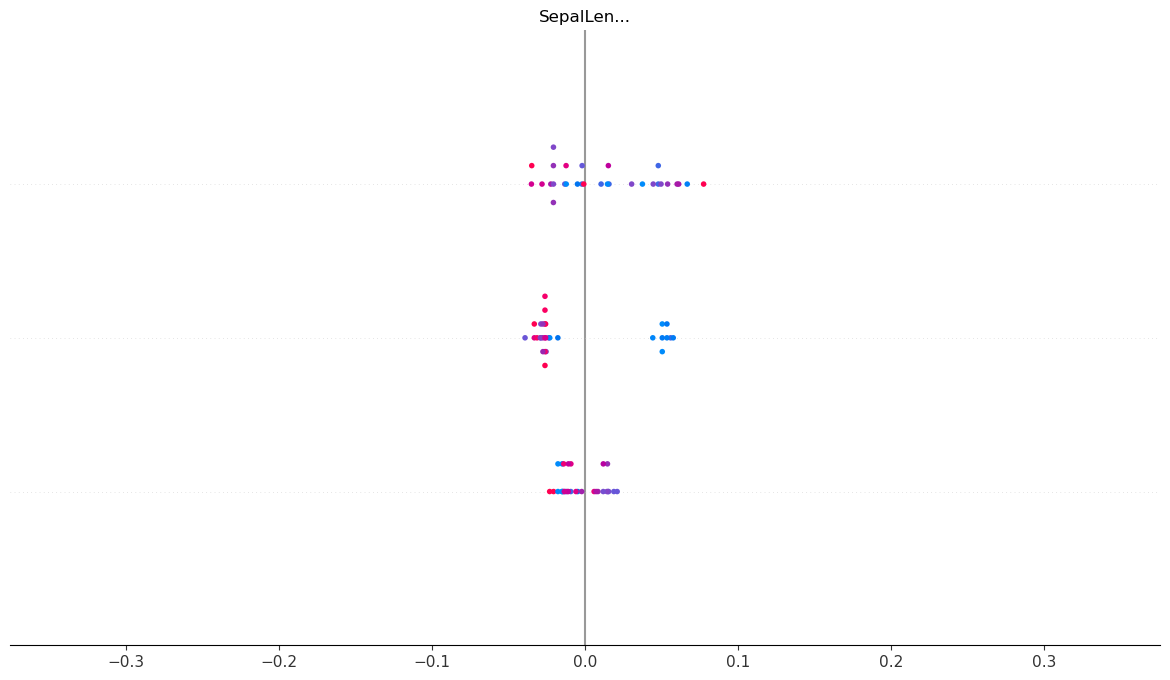

In [17]:
# ============================
# 🚀 Start MLflow Run
# ============================
with mlflow.start_run() as run:
    model_name = f"RandomForest_Iris_v1.0.0"
    training_time_start = time.time()

    # 📈 Model Training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

    # ✅ Log Environment Automatically
    mlflow.log_params({
        "python_version": platform.python_version(),
        "os_platform": f"{platform.system()} {platform.release()}",
        "sklearn_version": sklearn.__version__,
        "pandas_version": pd.__version__,
        "numpy_version": np.__version__,
        "matplotlib_version": matplotlib.__version__,
        "seaborn_version": sns.__version__,
        "shap_version": shap.__version__,
    })

    # ✅ Git and Notebook Metadata
    mlflow.set_tag("git_commit_hash", commit_hash)
    mlflow.set_tag("notebook_name", "RQ1.ipynb")

    # ✅ Dataset Metadata Tags
    mlflow.set_tag("dataset_name", "Iris")
    mlflow.set_tag("dataset_version", "1.0.0")
    mlflow.set_tag("dataset_id", "iris_local")

    # ✅ Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_path = "confusion_matrix.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)

    # ✅ SHAP Summary
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    shap_path = "shap_summary.png"
    plt.savefig(shap_path)
    mlflow.log_artifact(shap_path)

    # ✅ FAIR4ML-style Metadata JSON
    fair4ml_metadata = {
        "@type": "MLModel",
        "name": model_name,
        "algorithm": "RandomForestClassifier",
        "hyperParameters": model.get_params(),
        "trainingDataset": {
            "name": "Iris",
            "version": "1.0.0",
            "identifier": "iris_local"
        },
        "trainingMetrics": {
            "accuracy": acc,
            "roc_auc": auc,
            "precision": precision_score(y_test, y_pred, average='macro'),
            "recall": recall_score(y_test, y_pred, average='macro'),
            "f1_score": f1_score(y_test, y_pred, average='macro')
        },
        "environment": {
            "python": platform.python_version(),
            "os": f"{platform.system()} {platform.release()}",
            "libraries": {
                "sklearn": sklearn.__version__,
                "pandas": pd.__version__,
                "numpy": np.__version__
            }
        },
        "source": {
            "git_commit": commit_hash,
            "notebook": "RQ1.ipynb"
        }
    }
    # ✅ Commit changes to Git after successful run
    repo.git.add(A=True)
    repo.index.commit("Auto commit after successful training")
    repo.remotes.origin.push()
    
    # 🔁 Get new commit hash
    new_commit_hash = repo.head.object.hexsha
    
    # 🔁 Log updated Git commit
    mlflow.set_tag("git_commit_hash", new_commit_hash)
    mlflow.log_param("git_commit_hash", new_commit_hash)

    with open("model_metadata_fair4ml.json", "w") as f:
        json.dump(fair4ml_metadata, f, indent=2)
    mlflow.log_artifact("model_metadata_fair4ml.json")
    mlflow.end_run()

   


In [ ]:
  # ✅ Commit changes to Git after successful run
    repo.git.add(A=True)
    repo.index.commit(f"Auto commit after successful training: {commit_hash}")
    origin = repo.remote(name='origin')
    origin.push()

    mlflow.end_run()

In [ ]:
 with open("model_metadata_fair4ml.json", "w") as f:
        json.dump(fair4ml_metadata, f, indent=2)
    mlflow.log_artifact("model_metadata_fair4ml.json")
